In [1]:
import os
import tqdm
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
meth1_path = "/media/sayalialaatkar/T9/Sayali/FoundationModels/scGPT-main/results/zero-shot/cell_embeddings_full_body/"
meth2_path ="/media/sayalialatkar/T9/Sayali/FoundationModels/scMulan-main/results/zero-shot/cell embeddings/"
meth3_path = "/media/sayalialatkar/T9/Sayali/FoundationModels/UCE_venv/UCE-main/results/cell_embeddings/zero-shot/"
meth4_path  = "/media/sayalialatkar/T9/Sayali/FoundationModels/scFoundation/results/"

In [4]:
method_dict = {"scGPT":meth1_path, "scMulan": meth2_path, "UCE":meth3_path, "scFoundation": meth4_path}

In [5]:
adata = ad.read_h5ad("/media/sayalialatkar/T9/Sayali/FoundationModels/scFoundation/results/partition_1_scFoundation.h5ad")
adata

AnnData object with n_obs × n_vars = 14815 × 34890
    obs: 'Channel', 'class', 'subclass', 'donor'
    var: 'feature_name', 'gene_id', 'gene_name', 'gene_type', 'gene_chrom', 'gene_start', 'gene_end', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'ribosomal', 'mitochondrial', 'protein_coding', 'mitocarta_genes', 'robust_protein_coding', 'mean', 'bins'
    obsm: 'X_scFoundation'

In [6]:
meth1_files = os.listdir(meth1_path)
meth2_files = os.listdir(meth2_path)
meth3_files = [x for x in os.listdir(meth3_path) if "uce" in x]
meth4_files = os.listdir(meth4_path)

def get_frobenius_norm(m1,m2):
    diff = m1 - m2
    fro_norm = np.linalg.norm(diff)
    return fro_norm

In [9]:
donor_names = []
partition_names = []
methods = list(method_dict.keys())
pairwise_differences = {}

for file in tqdm.tqdm(meth1_files):
    if "all" in file:
        continue
    partition_number = file.split(".")[0]
    adata_1 = ad.read_h5ad(f"{meth1_path}{file}")
    adata_2 = ad.read_h5ad(f"{meth2_path}{file}")
    adata_3 = ad.read_h5ad(f"{meth3_path}{partition_number}_uce_adata.h5ad")
    adata_4 = ad.read_h5ad(f"{meth4_path}{partition_number}_scFoundation.h5ad")

    for donor in adata_1.obs["donor"].unique():
        
        adata_1_sub = adata_1[adata_1.obs["donor"]==donor]
        adata_2_sub = adata_2[adata_2.obs["donor"]==donor]
        adata_3_sub = adata_3[adata_3.obs["donor"]==donor]
        adata_4_sub = adata_4[adata_4.obs["donor"]==donor]

        x_emb_1 = adata_1_sub.obsm["X_scGPT"]
        x_emb_2 = adata_2_sub.obsm["X_scMulan"]
        x_emb_3 = adata_3_sub.obsm["X_uce"]
        x_emb_4 = adata_4_sub.obsm["X_scFoundation"]

        emb_dict = {"scGPT":pdist(x_emb_1),"scMulan":pdist(x_emb_2),"UCE":pdist(x_emb_3), "scFoundation":pdist(x_emb_4)}
        for i,m1 in enumerate(methods):
            for m2 in methods[i+1:]:
                #fro_norm = get_frobenius_norm(emb_dict[m1],emb_dict[m2])
                cos_sim = cosine_similarity(squareform(emb_dict[m1]),squareform(emb_dict[m2]))

                if f"{m1}_{m2}" not in pairwise_differences:
                    pairwise_differences[f"{m1}_{m2}"] = [cos_sim]
                else:
                    pairwise_differences[f"{m1}_{m2}"].append(cos_sim)

        donor_names.append(donor)
        partition_names.append(partition_number)

 18%|█▊        | 33/185 [2:14:00<11:24:23, 270.15s/it]

: 

In [8]:
cos_sim = cosine_similarity(squareform(emb_dict[m1]),squareform(emb_dict[m2]))

NameError: name 'emb_dict' is not defined

In [81]:
x_emb_1.shape, x_emb_2.shape, x_emb_3.shape

((7524, 512), (7524, 1120), (7524, 1280))

In [54]:
pairwise_differences_df = pd.DataFrame(pairwise_differences)
pairwise_differences_df["donor"] = donor_names
pairwise_differences_df["partition"] = partition_names
pairwise_differences_df

,scGPT_scMulan,scGPT_UCE,scMulan_UCE,donor,partition
0,60093.009365,4095.027188,56082.100475,M22156,partition_3
1,69455.995802,4907.957600,64641.564318,M22640,partition_3
2,40597.657667,2905.288317,37759.887631,M29124,partition_3
3,45524.971328,3189.291924,42414.805009,M3114,partition_3
4,48198.780329,3762.237423,44510.432247,M12249,partition_2
...,...,...,...,...,...
1038,1880.314050,167.317418,1717.944938,M62951,partition_185
1039,13047.174684,1061.531556,12030.784359,M723187,partition_185
1040,24281.535461,1798.425704,22512.788799,M77159,partition_185
1041,8689.746067,711.532937,7994.722396,M70978,partition_185


In [53]:
pairwise_differences_df.to_csv("./pairwise_cell_cell_similarity_l2_norm_scgpt_pretrained_scmulan_uce.csv")

In [7]:
pairwise_differences_df = pd.read_csv("/media/sayali/External Dr/Sayali/Foundation Models/scBrainLLM/pairwise_donor_cosine_similarity.csv", delimiter=",")
pairwise_differences_df# = pairwise_differences_df[["scGPT_scMulan","scGPT_UCE","scMulan_UCE"]]

,Unnamed: 0,scGPT_scMulan,scGPT_UCE,scGPT_scFoundation,scGPT_Geneformer,scMulan_UCE,scMulan_scFoundation,scMulan_Geneformer,UCE_scFoundation,UCE_Geneformer,scFoundation_Geneformer,donor
0,0,0.969597,0.969978,0.907684,0.873854,0.988318,0.939603,0.915912,0.932049,0.910785,0.918617,M84161


In [5]:
pairwise_differences_df["scGPT_scMulan"].values

array(['[[0.97179435 0.96362435 0.97087184 ... 0.96628448 0.96283472 0.97161805]\n [0.979182   0.97510022 0.97796165 ... 0.97597359 0.97424702 0.97915689]\n [0.97004914 0.96019121 0.96918802 ... 0.96394357 0.95933641 0.97010094]\n ...\n [0.98078264 0.9767703  0.98091374 ... 0.97799322 0.97635236 0.98030697]\n [0.97463192 0.96585244 0.97364909 ... 0.96878766 0.96525437 0.97441301]\n [0.96886852 0.95944376 0.96729284 ... 0.96290663 0.95839761 0.96920304]]'],
      dtype=object)

In [75]:
# pairwise_differences_df = (pairwise_differences_df - pairwise_differences_df.min()) / (pairwise_differences_df.max() - pairwise_differences_df.min())

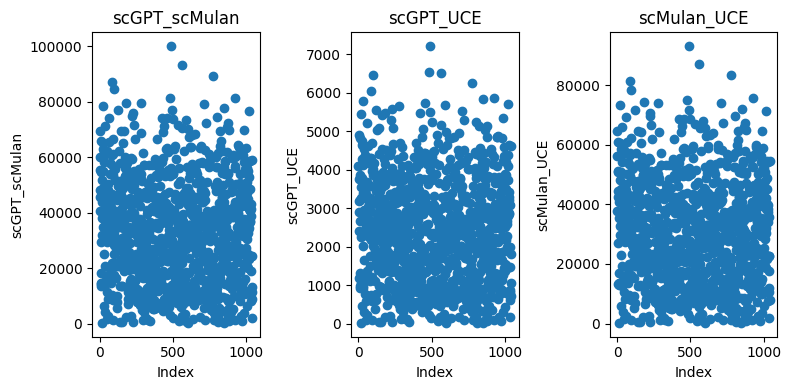

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4), sharex=True)

# Plot each column as a scatter plot
for ax, col in zip(axes, pairwise_differences_df.columns[:3]):
    ax.scatter(range(len(pairwise_differences_df[col])), pairwise_differences_df[col])
    ax.set_title(f"{col}")
    ax.set_xlabel("Index")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

In [79]:
pairwise_differences_df_melt = pairwise_differences_df[["scGPT_scMulan","scGPT_UCE","scMulan_UCE"]].melt()
pairwise_differences_df_melt

,variable,value
0,scGPT_scMulan,60093.009365
1,scGPT_scMulan,69455.995802
2,scGPT_scMulan,40597.657667
3,scGPT_scMulan,45524.971328
4,scGPT_scMulan,48198.780329
...,...,...
3124,scMulan_UCE,1717.944938
3125,scMulan_UCE,12030.784359
3126,scMulan_UCE,22512.788799
3127,scMulan_UCE,7994.722396


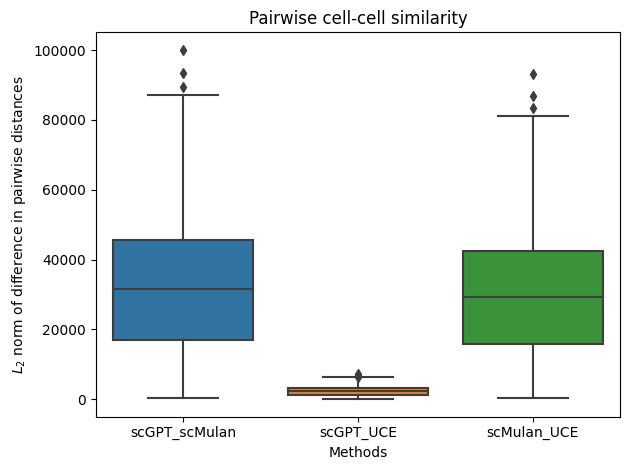

In [82]:
sns.boxplot(x='variable', y='value', data=pairwise_differences_df_melt)

# Customize and display the plot.
plt.title("Pairwise cell-cell similarity")
plt.xlabel("Methods")
plt.ylabel(r"$L_2$ norm of difference in pairwise distances")
plt.tight_layout()
plt.savefig("./PCS_score.png")
plt.show()